Importing Libraries

In [65]:
import matplotlib.pyplot as plt
import numpy as np

Importing Data

In [66]:
data_set = np.genfromtxt("hw04_data_set.csv", delimiter = ",",skip_header = 1)
training = data_set[:150]
test = data_set[150:]

X_train = training[:, 0]
y_train = training[:, 1]

X_test = test[:, 0]
y_test = test[:, 1]
N_train = len(X_train)




Tree Inference

In [67]:
def tree_inference(X, Y, P):
    
    # create necessary data structures
    node_indices = {}
    is_terminal = {}
    need_split = {}
    node_splits = {}

    # put all training instances into the root node
    node_indices[1] = np.array(range(X.shape[0]))
    is_terminal[1] = False
    need_split[1] = True
    
    # learning algorithm
    while True:
        # find nodes that need splitting
        split_nodes = [key for key, value in need_split.items()
                       if value == True]
        # check whether we reach all terminal nodes
        if len(split_nodes) == 0:
            break
        # find best split positions for all nodes
        for split_node in split_nodes:
            data_indices = node_indices[split_node]
            need_split[split_node] = False
            if len(node_indices[split_node]) <= P:
                is_terminal[split_node] = True
            else:
                is_terminal[split_node] = False
                
                unique_values = np.sort(np.unique(X[data_indices]))
                split_positions = (unique_values[1:len(unique_values)] + \
                                   unique_values[0:(len(unique_values) - 1)]) / 2
                split_scores = np.repeat(0.0, len(split_positions))
                for s in range(len(split_positions)):
                    left_indices = data_indices[X[data_indices] > split_positions[s]]
                    right_indices = data_indices[X[data_indices] <= split_positions[s]]
                    split_scores[s] = (np.sum((Y[left_indices] - np.mean(Y[left_indices]))**2) + \
                                      np.sum((Y[right_indices] - np.mean(Y[right_indices]))**2))/len(data_indices)
                
                best_scores = np.min(split_scores)
                best_splits = split_positions[np.argmin(split_scores)]
                node_splits[split_node] = best_splits
                
                # create left node using the selected split
                left_indices_final = data_indices[X[data_indices] > best_splits]
                node_indices[2 * split_node] = left_indices_final
                is_terminal[2 * split_node] = False
                need_split[2 * split_node] = True
      
                # create right node using the selected split
                right_indices_final = data_indices[X_train[data_indices] <= best_splits]
                node_indices[2 * split_node + 1] = right_indices_final
                is_terminal[2 * split_node + 1] = False
                need_split[2 * split_node + 1] = True
                
            # predictions and left & right borders
            terminal_nodes = [key for key, value in is_terminal.items()
                    if value == True]
                                  
            predictions = np.asarray([np.mean(Y[node_indices[items]]) for items in terminal_nodes])
            left_borders = np.array([])
            right_borders = np.array([])
            
            for i, terminal in enumerate(terminal_nodes):
                if len(np.array(list(node_splits.values()))[np.array(list(node_splits.values())) < np.min(X[node_indices[terminal]])]) == 0:
                    left_borders = np.append(left_borders, 0)
                else:
                    left_borders = np.append(left_borders,np.max(np.array(list(node_splits.values()))[np.array(list(node_splits.values())) < np.min(X[node_indices[terminal]])]))
            
            for terminal in terminal_nodes:
                if len(np.array(list(node_splits.values()))[np.array(list(node_splits.values())) > np.max(X[node_indices[terminal]])]) == 0:
                    right_borders = np.append(right_borders, 2)
                else:
                    right_borders = np.append(right_borders, np.min(np.array(list(node_splits.values()))[np.array(list(node_splits.values())) > np.max(X[node_indices[terminal]])]))    
                
            order = np.argsort(left_borders)
            sorted_left_borders = left_borders[order]
            sorted_right_borders = right_borders[order]
            sorted_predictions = predictions[order]
            
    return node_indices, node_splits, sorted_predictions, terminal_nodes, sorted_left_borders, sorted_right_borders

Plotting Test and Training Data Points

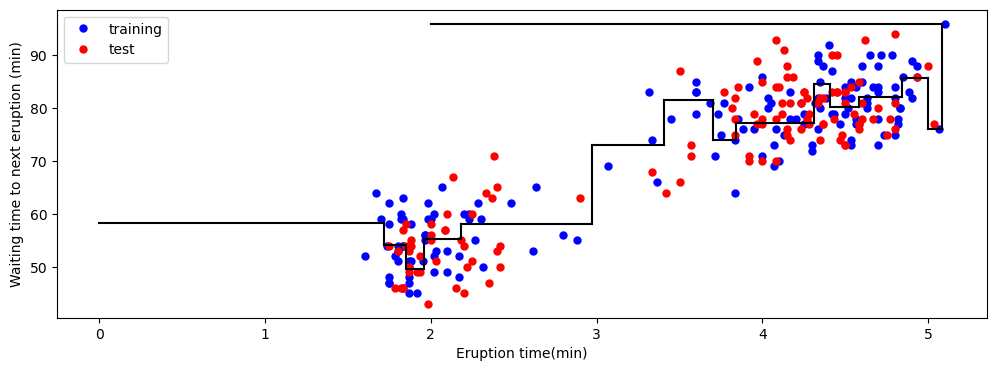

In [68]:
node_indices, node_splits, sorted_predictions, terminal_nodes, sorted_left_borders, sorted_right_borders = tree_inference(X_train, y_train, 25)

plt.figure(figsize = (12, 4))
plt.plot(X_train, y_train, "b.", markersize = 10)
plt.plot(X_test,y_test, "r.", markersize = 10)
plt.xlabel("Eruption time(min)")
plt.ylabel("Waiting time to next eruption (min)")
plt.legend(['training','test'])

for b in range(len(sorted_left_borders)):
    plt.plot([sorted_left_borders[b], sorted_right_borders[b]], [sorted_predictions[b], sorted_predictions[b]], "k-")
for b in range(len(sorted_left_borders) - 1):
    plt.plot([sorted_right_borders[b], sorted_right_borders[b]], [sorted_predictions[b], sorted_predictions[b + 1]], "k-")    
plt.show()

RMSE Calculation

In [69]:
def calculateRMSE(X, Y):
    y_predicted = np.zeros(len(Y))
    sum_of_errors = 0
    for i in range(len(Y)):
        y_predicted[i] = sorted_predictions[np.argmax(X[i] <= sorted_left_borders)-1]
    
    RMSE = np.sqrt(np.mean((Y - y_predicted)**2))
    return RMSE

In [70]:
RMSE = calculateRMSE(X_train, y_train)
print(f'RMSE on training set is {RMSE} when P is 25')
RMSE_test = calculateRMSE(X_test,y_test)
print(f'RMSE on test set is {RMSE_test} when P is 25')

RMSE on training set is 4.541214189194451 when P is 25
RMSE on test set is 6.454083413352087 when P is 25


In [73]:
P_list = np.arange(5,50,5)

RMSE_training_list = []
RMSE_test_list = []

for P in P_list:
    node_indices, node_splits, sorted_predictions, terminal_nodes, sorted_left_borders, sorted_right_borders = tree_inference(X_train, y_train, P)
    RMSE_training_list.append(calculateRMSE(X_train, y_train))
    RMSE_test_list.append(calculateRMSE(X_test, y_test))

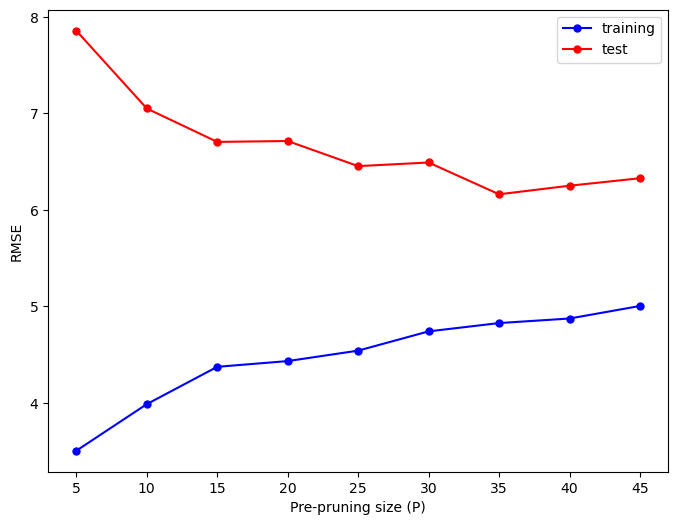

In [75]:
plt.figure(figsize=(8,6))
plt.plot(P_list, RMSE_training_list, 'b', marker = "o", markersize = "5")
plt.plot(P_list, RMSE_test_list, 'r', marker = "o", markersize = "5")
plt.xlabel("Pre-pruning size (P)")
plt.ylabel("RMSE")
plt.legend(['training','test'])
plt.show()